In [1]:
import cantata
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cantata.plotting import output as cp
from cantata import cfg

In [2]:
figsize = (14,5)

In [3]:
cfg.batch_size = 1
cfg.model.populations.Ex1.noise_weight = 3e-3
cfg.model.populations.In1.noise_weight = 3e-3
cfg.model.populations.Ex1.targets.Ex1.A_d = 0.003
cfg.model.populations.Ex1.targets.Ex1.A_p = 0.08
# cfg.model.tau_dth = 1.

In [4]:
second = int(1/cfg.time_step)

In [5]:
cfg.n_steps = int(10 * second)
rate_off, rate_on = 0, 0 # Hz
t_off, t_on = .15*second, .15*second
t_wait = 1*second

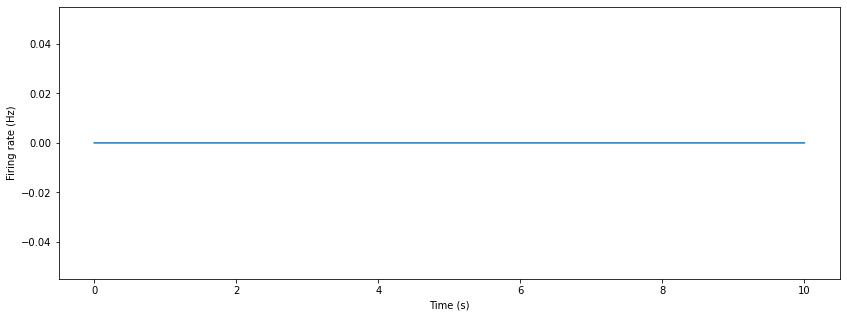

In [6]:
inputs = torch.where(torch.arange(cfg.n_steps)%(t_on+t_off) >= t_off, rate_on, rate_off)
inputs[:t_wait] = rate_off
inputs[-t_wait:] = rate_off

plt.figure(figsize=figsize)
plt.plot(np.arange(cfg.n_steps) * cfg.time_step, inputs)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')

inputs = inputs.reshape(1,-1,1).expand(cfg.batch_size, -1, cfg.n_inputs)

In [7]:
m = cantata.Module()
with torch.no_grad():
    record = m.forward(inputs, ['W', 'w_stdp'])

In [8]:
batch = 0

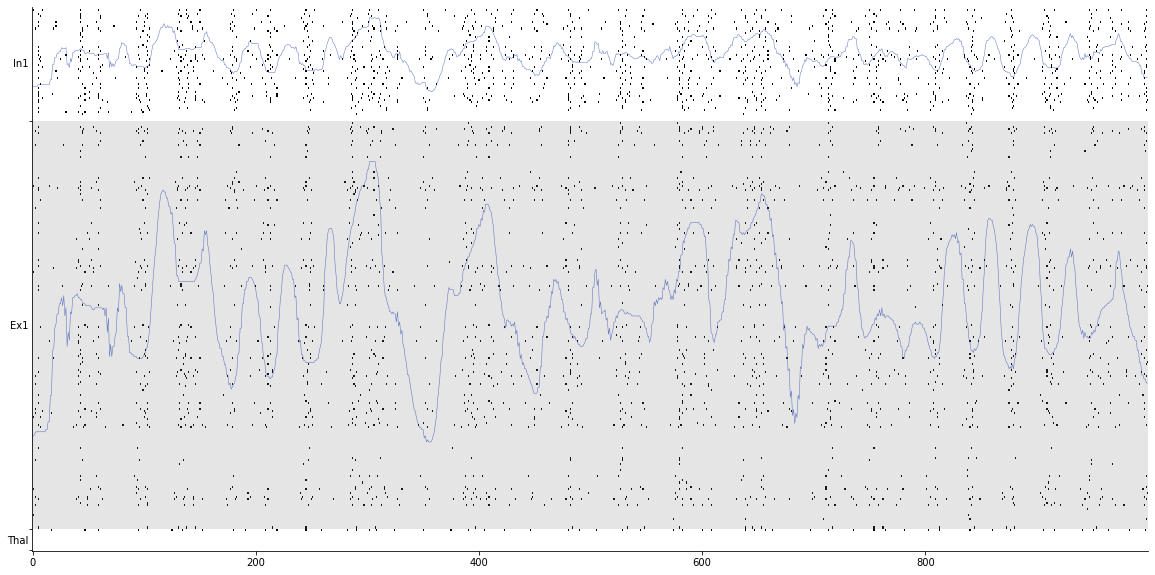

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots()
spikes = record.out[batch:batch+1,9000:]
cp.raster(spikes, ax, rates=cp.get_rates(spikes, kwidth=50), c='#1133AAAA', lw=0.5);

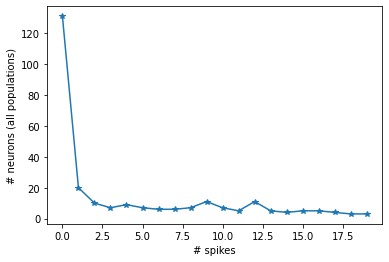

In [10]:
plt.plot(torch.histc(record.out[batch].sum(dim=0), 20).cpu().numpy(), '*-')
plt.xlabel('# spikes')
plt.ylabel('# neurons (all populations)');

Mean firing rates:
Thal: 0.0 Hz
Ex1: 20.0 Hz
In1: 35.1 Hz


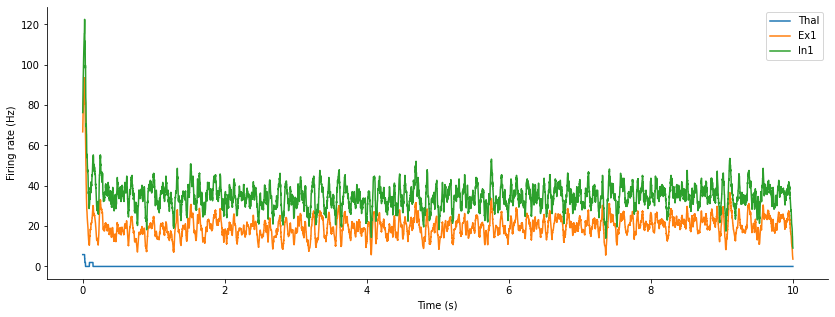

In [11]:
rates = cp.get_rates(record.out, kwidth=51)
t = np.arange(cfg.n_steps) / second
plt.figure(figsize=figsize)
print('Mean firing rates:')
for i,p in enumerate(cfg.model.populations.keys()):
    plt.plot(t, rates[batch,i].cpu(), label=p)
    mean = rates[batch,i].mean().item()
    print(f'{p}: {mean:.1f} Hz')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Time (s)')
plt.legend()
sns.despine()

tensor([0.5635, 0.5635, 0.5635,  ..., 0.9882, 0.9882, 0.9882], device='cuda:0')
tensor([0.6293, 0.6293, 0.6293,  ..., 0.6203, 0.6203, 0.6203], device='cuda:0')
tensor([0.7884, 0.7884, 0.7884,  ..., 0.7873, 0.7873, 0.7873], device='cuda:0')
tensor([0.8227, 0.8227, 0.8227,  ...,    nan,    nan,    nan], device='cuda:0')
tensor([0.6268, 0.6268, 0.6268,  ...,    nan,    nan,    nan], device='cuda:0')
tensor([0.6283, 0.6283, 0.6283,  ..., 0.7560, 0.7560, 0.7560], device='cuda:0')
tensor([0.7345, 0.7345, 0.7345,  ...,    nan,    nan,    nan], device='cuda:0')
tensor([0.8417, 0.8417, 0.8417,  ...,    nan,    nan,    nan], device='cuda:0')
tensor([0.7082, 0.7082, 0.7082,  ..., 0.6699, 0.6699, 0.6699], device='cuda:0')
tensor([0.6459, 0.6459, 0.6459,  ..., 0.6253, 0.6253, 0.6253], device='cuda:0')


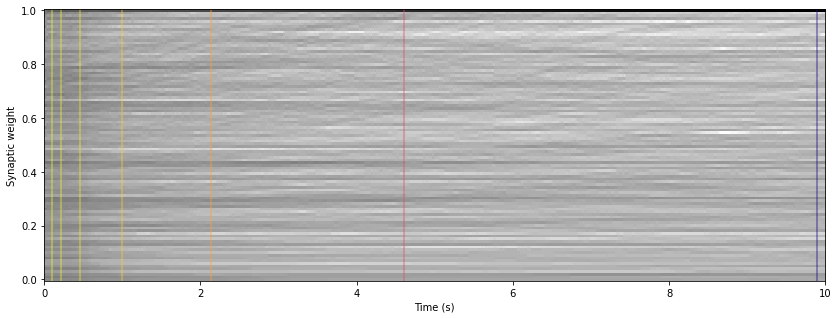

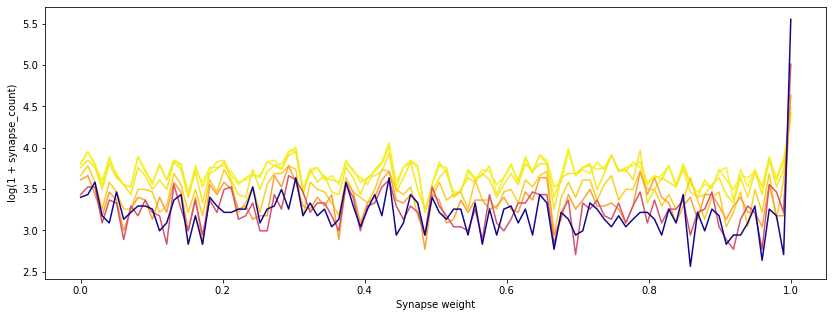

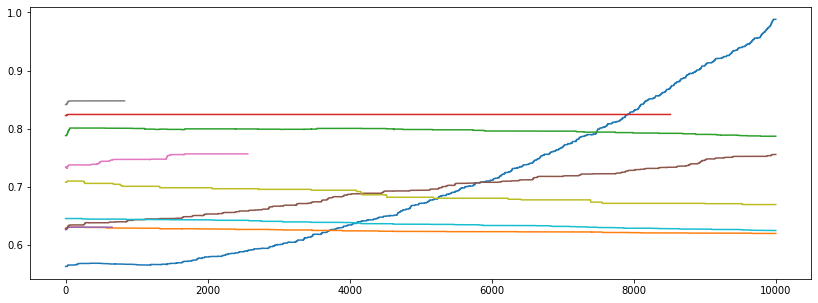

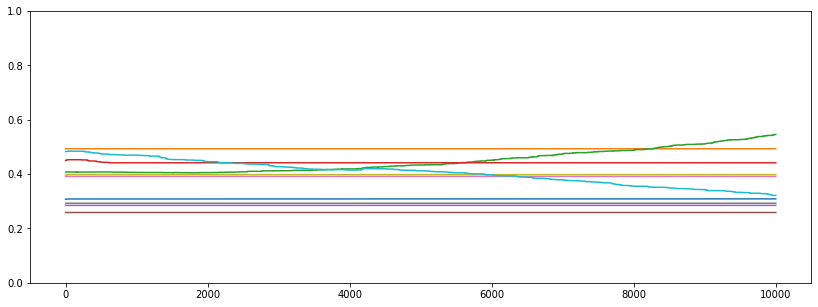

In [18]:
ticks, _,_ = cp.get_ticks()
mask = (record.W > 0).cpu()
mask[:ticks[1]] = False
mask[ticks[2]:] = False
mask[:,:ticks[1]] = False
mask[:,ticks[2]:] = False
w = record.w_stdp[batch] * record.W
wmax = cfg.model.stdp_wmax_total
n_bins = 100
bins = np.linspace(0,wmax,n_bins)
w_hist = np.empty((cfg.n_steps, n_bins))
for i in range(cfg.n_steps):
    w_hist[i] = torch.log(1 + torch.histc(w[i][mask], n_bins, 0, wmax)).cpu().numpy()
#     w_hist[i] = torch.histc(w[i][mask], n_bins, 0, wmax).cpu().numpy()

plt.figure(figsize=figsize)
plt.imshow(w_hist.T, cmap=plt.cm.gray_r, origin='lower', aspect='auto', interpolation='none',
          extent=(-.5/second, (cfg.n_steps+.5)/second, -.5/n_bins, (n_bins+.5)/n_bins*wmax))
plt.xlabel('Time (s)')
plt.ylabel('Synaptic weight')

details = np.logspace(np.log10(0.01*cfg.n_steps),np.log10(0.99*cfg.n_steps),7)
cm = plt.cm.plasma_r
for d in details:
    plt.axvline(d/second, alpha=0.5, c=cm(d/cfg.n_steps))

plt.figure(figsize=figsize)
for d in details:
    plt.plot(bins, w_hist[int(d)], c=cm(d/cfg.n_steps))
plt.xlabel('Synapse weight')
plt.ylabel('log(1 + synapse_count)')

plt.figure(figsize=figsize)
sel = torch.nonzero(mask)
for i in range(10):
    x,y = sel[torch.randint(len(sel),(1,))][0]
    plt.plot(w[:,x,y].cpu().numpy())
    print(w[:,x,y])

plt.figure(figsize=figsize)
t = int(0.9 * cfg.n_steps)
sel = torch.nonzero((w[t]<0.75) * (w[t]>0.25))
for i in range(10):
    x,y = sel[torch.randint(len(sel),(1,))][0]
    plt.plot(w[:,x,y].cpu().numpy())
plt.ylim([0,1])

del w

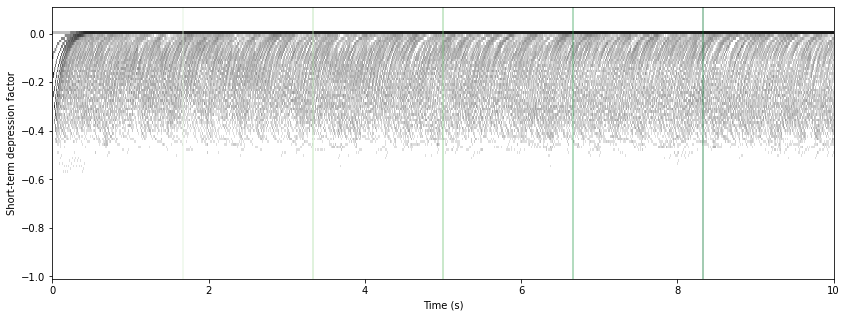

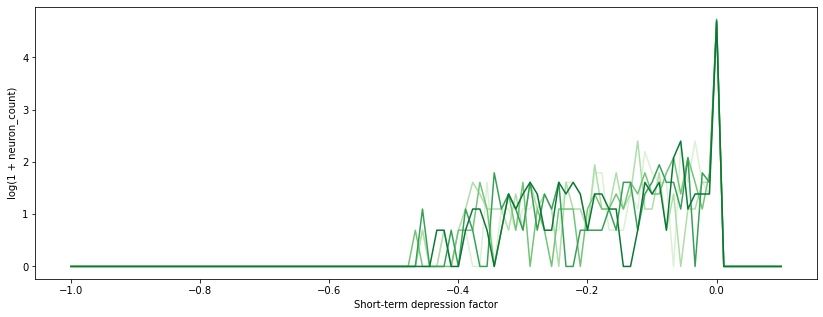

In [13]:
wp = record.w_p[batch, :, ticks[1]:ticks[2]]
wp_hist = np.empty((cfg.n_steps, n_bins))
bins = np.linspace(-1,0.1,n_bins)
for i in range(cfg.n_steps):
    wp_hist[i] = torch.log(1 + torch.histc(wp[i], n_bins, bins[0], bins[-1])).cpu()
del wp
plt.figure(figsize=figsize)
plt.imshow(wp_hist.T, cmap=plt.cm.gray_r, origin='lower', aspect='auto', interpolation='none',
          extent=(-.5/second, (cfg.n_steps+.5)/second, bins[0] - .5/(n_bins/2), bins[-1] + .5/(n_bins/2)))
plt.xlabel('Time (s)')
plt.ylabel('Short-term depression factor')
details = np.linspace(0,cfg.n_steps,7)[1:-1]
cm = plt.cm.Greens
for d in details:
    plt.axvline(d/second, alpha=0.5, c=cm(d/cfg.n_steps))

plt.figure(figsize=figsize)
for d in details:
    plt.plot(bins, wp_hist[int(d)], c=cm(d/cfg.n_steps))
plt.xlabel('Short-term depression factor')
plt.ylabel('log(1 + neuron_count)');